In [1]:
!curl http://datosabiertos.salud.gob.mx/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip -o covid19.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  197M  100  197M    0     0  4746k      0  0:00:42  0:00:42 --:--:-- 4725k 4751k      0  0:00:42  0:00:22  0:00:20 4764k


In [1]:
from pandas import read_csv, to_datetime

In [2]:
df = read_csv("covid19.zip", compression="zip", encoding="latin-1")
df["FECHA_ACTUALIZACION"] = to_datetime(df["FECHA_ACTUALIZACION"])
df["FECHA_INGRESO"] = to_datetime(df["FECHA_INGRESO"])
df["FECHA_SINTOMAS"] = to_datetime(df["FECHA_SINTOMAS"])
df["FECHA_DEF"] = df["FECHA_DEF"].where(df["FECHA_DEF"] != "9999-99-99", None)
df["FECHA_DEF"] = to_datetime(df["FECHA_DEF"])

/usr/local/Caskroom/miniconda/base/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
index = df['CLASIFICACION_FINAL'] == 6
sospechosos = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

index = df['CLASIFICACION_FINAL'].isin([1, 2, 3])
confirmados = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

index = df['CLASIFICACION_FINAL'] == 7
negativos = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3])) & (df['FECHA_DEF'] != '9999-99-99')
defunciones = df[index].groupby(['ENTIDAD_UM', 'FECHA_DEF']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3])) & (df['FECHA_DEF'] == '9999-99-99')
vivos = df[index].groupby(['ENTIDAD_UM', 'FECHA_DEF']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3]) & (df['TIPO_PACIENTE'] == 2))
hospitalizados = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3]) & (df['UCI'] == 1))
cuidados_intensivos = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

index = (df['CLASIFICACION_FINAL'].isin([1, 2, 3]) & (df['TIPO_PACIENTE'] == 1))
ambulatorios = df[index].groupby(['ENTIDAD_UM', 'FECHA_INGRESO']).count()['ORIGEN']

In [4]:
sospechosos_cdmx = sospechosos[9]
confirmados_cdmx = confirmados[9]
negativos_cdmx = negativos[9]
defunciones_cdmx = defunciones[9]
hospitalizados_cdmx = hospitalizados[9]
uci_cdmx = cuidados_intensivos[9]
ambulatorios_cdmx = ambulatorios[9]

In [5]:
acum_sospechosos_cdmx = sospechosos_cdmx.cumsum()
acum_confirmados_cdmx = confirmados_cdmx.cumsum()
acum_negativos_cdmx = negativos_cdmx.cumsum()

acum_defunciones_cdmx = defunciones_cdmx.cumsum()
acum_hospitalizados_cdmx = hospitalizados_cdmx.cumsum()
acum_uci_cdmx = uci_cdmx.cumsum()
acum_ambulatorios_cdmx = ambulatorios_cdmx.cumsum()

In [6]:
pruebas_cdmx = (confirmados_cdmx + negativos_cdmx).fillna(0)
positividad_cdmx = confirmados_cdmx/pruebas_cdmx

In [7]:
positividad_cdmx[0] = 0
positividad_cdmx = positividad_cdmx.fillna(method="ffill")

In [8]:
def filter(series, days=7):
    from pandas import Series
    from control import tf, forced_response
    G = tf([1], [days,1])
    xs = series.values
    x0 = xs[0]
    t1, y1 = forced_response(G, T=range(len(xs)), U=xs, X0=0)
    return Series(data=y1, index=series.index)

In [9]:
fil_sospechosos_cdmx = filter(sospechosos_cdmx)
fil_confirmados_cdmx = filter(confirmados_cdmx)
fil_negativos_cdmx = filter(negativos_cdmx)
fil_positividad_cdmx = filter(positividad_cdmx)
fil_pruebas_cdmx = filter(pruebas_cdmx)
fil_hospitalizados_cdmx = filter(hospitalizados_cdmx)
fil_uci_cdmx = filter(uci_cdmx)
fil_ambulatorios_cdmx = filter(ambulatorios_cdmx)

In [10]:
from matplotlib.pyplot import figure, rcParams
from conf_matplotlib import conf_matplotlib_horizon
conf_matplotlib_horizon()

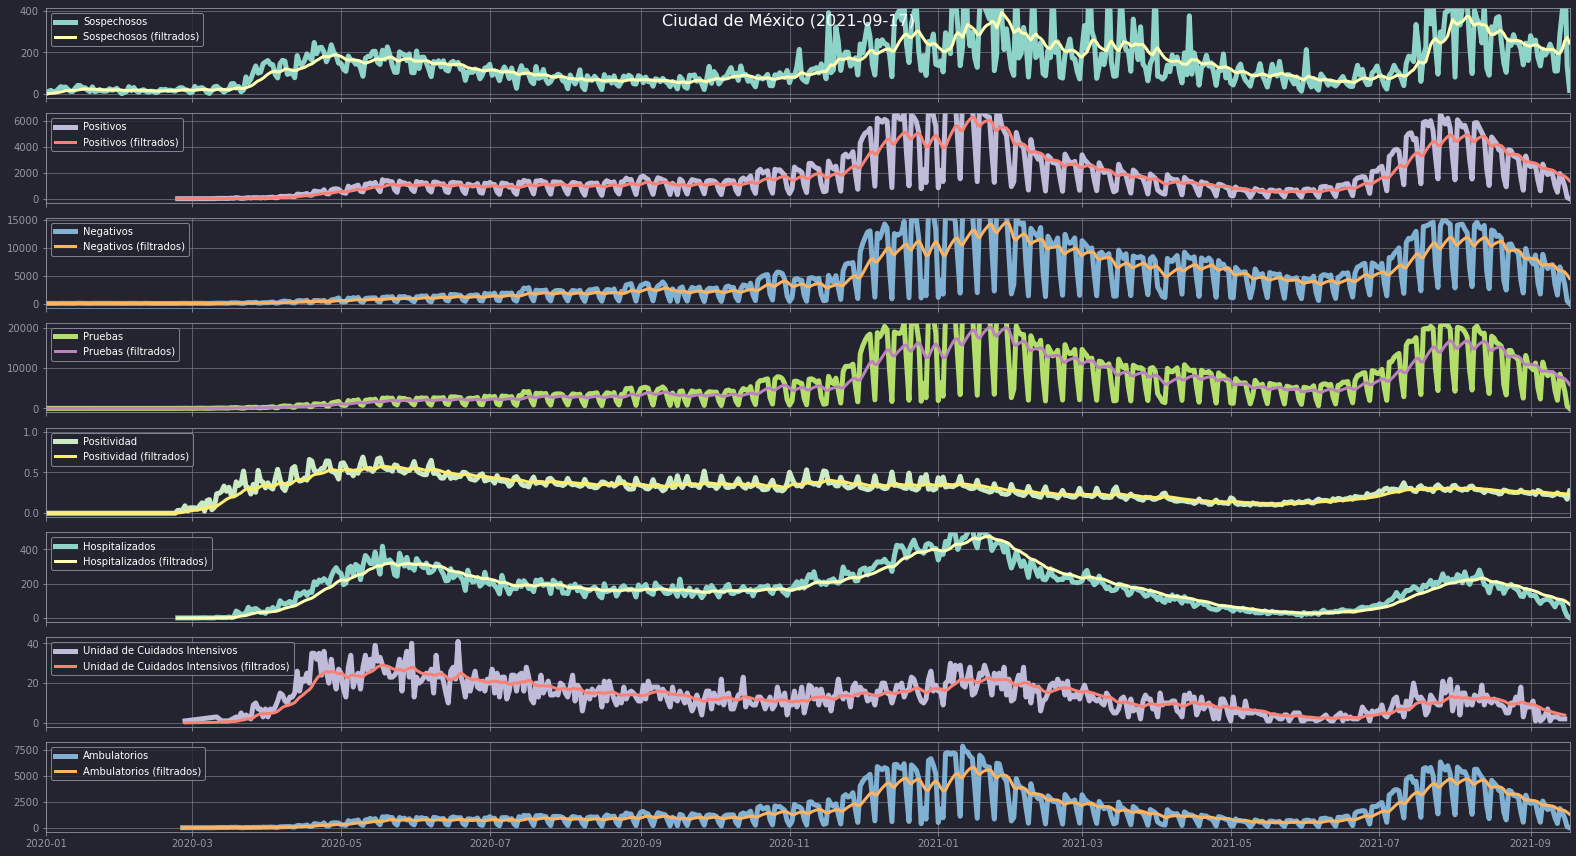

In [11]:
cycle = rcParams['axes.prop_cycle'].by_key()['color']

fig = figure(figsize=(22,12))
axs = fig.subplots(8, 1, gridspec_kw={'height_ratios': [2,2,2,2,2,2,2,2]}, sharex=True)
ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axs

lbl_sos = f"Sospechosos"
lbl_pos = f"Positivos"
lbl_ptv = f"Positividad"
lbl_neg = f"Negativos"
lbl_pru = f"Pruebas"
lbl_hos = f"Hospitalizados"
lbl_uci = f"Unidad de Cuidados Intensivos"
lbl_amb = f"Ambulatorios"

ax1.plot(sospechosos_cdmx, label=lbl_sos, c=cycle[0])
ax1.plot(fil_sospechosos_cdmx, label=lbl_sos + " (filtrados)", c=cycle[1], lw=3)

ax2.plot(confirmados_cdmx, label=lbl_pos, c=cycle[2])
ax2.plot(fil_confirmados_cdmx, label=lbl_pos + " (filtrados)", c=cycle[3], lw=3)

ax3.plot(negativos_cdmx, label=lbl_neg, c=cycle[4])
ax3.plot(fil_negativos_cdmx, label=lbl_neg + " (filtrados)", c=cycle[5], lw=3)

ax4.plot(pruebas_cdmx, label=lbl_pru, c=cycle[6])
ax4.plot(fil_pruebas_cdmx, label=lbl_pru + " (filtrados)", c=cycle[7], lw=3)

ax5.plot(positividad_cdmx, label=lbl_ptv, c=cycle[8])
ax5.plot(fil_positividad_cdmx, label=lbl_ptv + " (filtrados)", c=cycle[9], lw=3)

ax6.plot(hospitalizados_cdmx, label=lbl_hos, c=cycle[0])
ax6.plot(fil_hospitalizados_cdmx, label=lbl_hos + " (filtrados)", c=cycle[1], lw=3)

ax7.plot(uci_cdmx, label=lbl_uci, c=cycle[2])
ax7.plot(fil_uci_cdmx, label=lbl_uci + " (filtrados)", c=cycle[3], lw=3)

ax8.plot(ambulatorios_cdmx, label=lbl_amb, c=cycle[4])
ax8.plot(fil_ambulatorios_cdmx, label=lbl_amb + " (filtrados)", c=cycle[5], lw=3)

ax1.set_ylim(-0.05*max(fil_sospechosos_cdmx), 1.05*max(fil_sospechosos_cdmx))
ax2.set_ylim(-0.05*max(fil_confirmados_cdmx), 1.05*max(fil_confirmados_cdmx))
ax3.set_ylim(-0.05*max(fil_negativos_cdmx), 1.05*max(fil_negativos_cdmx))
ax4.set_ylim(-0.05*max(fil_pruebas_cdmx), 1.05*max(fil_pruebas_cdmx))
ax5.set_ylim(-0.05, 1.05)
ax6.set_ylim(-0.05*max(fil_hospitalizados_cdmx), 1.05*max(fil_hospitalizados_cdmx))

ax5.set_xlim(sospechosos_cdmx.index[0], sospechosos_cdmx.index[-1])

ax1.legend(loc="upper left")
ax2.legend(loc="upper left")
ax3.legend(loc="upper left")
ax4.legend(loc="upper left")
ax5.legend(loc="upper left")
ax6.legend(loc="upper left")
ax7.legend(loc="upper left")
ax8.legend(loc="upper left")

#fig.legend(loc="upper left")
fig.tight_layout()
fig.suptitle("Ciudad de México (" + str(sospechosos_cdmx.index[-1].date()) + ")", fontsize=16);

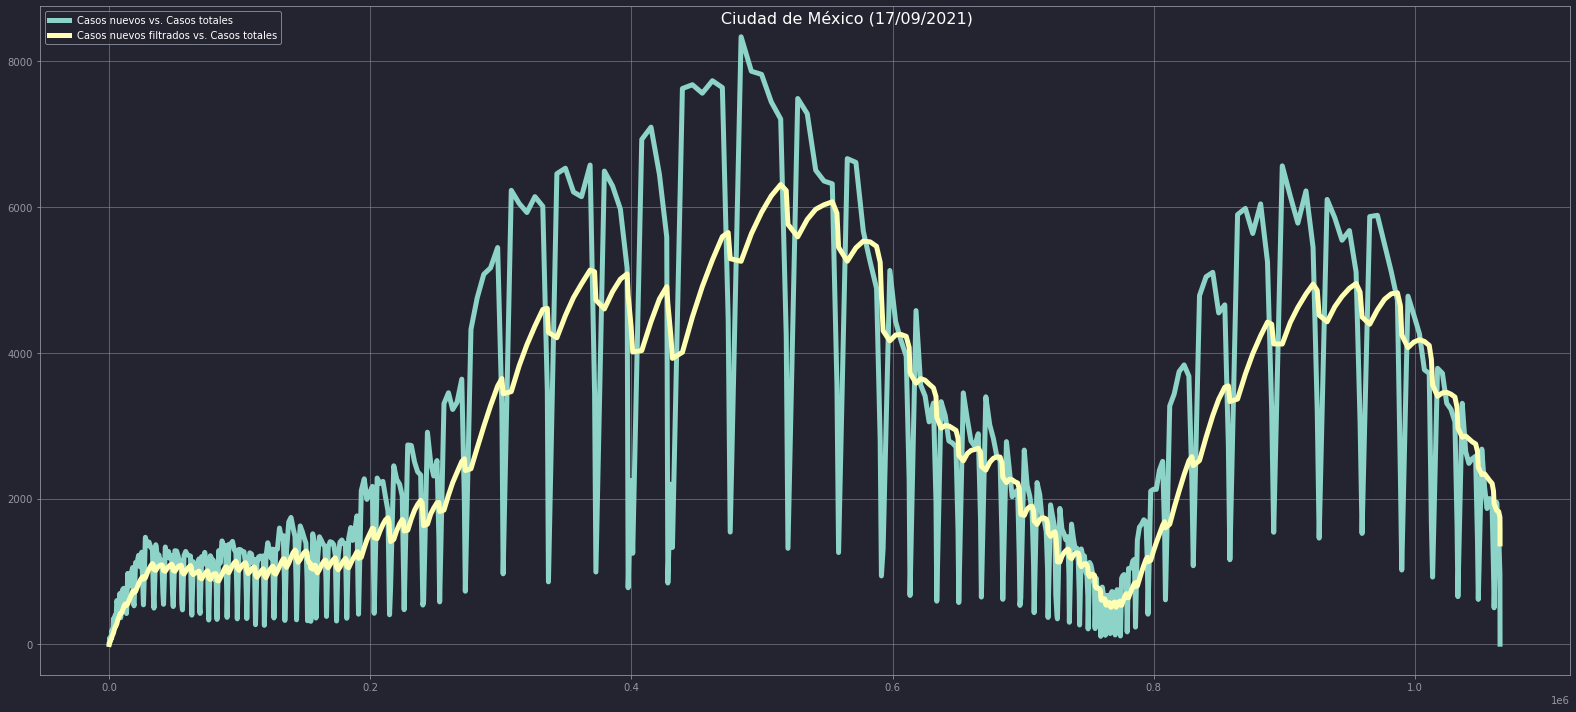

In [12]:
fig = figure(figsize=(22,10))
ax = fig.gca()

ax.plot(acum_confirmados_cdmx.values, confirmados_cdmx.values, label="Casos nuevos vs. Casos totales")
ax.plot(acum_confirmados_cdmx.values, fil_confirmados_cdmx.values, label="Casos nuevos filtrados vs. Casos totales")

#ax.set_xscale('log')
#ax.set_yscale('log')

ax.legend(loc="upper left")
fig.tight_layout()
fig.suptitle("                       Ciudad de México (" + confirmados_cdmx.index[-1].strftime("%d/%m/%Y") + ")", fontsize=16);

In [ ]:
from datetime import timedelta

In [ ]:
from pandas import DataFrame, date_range, concat, Series

In [ ]:
df_cdmx = df[df["ENTIDAD_UM"] == 9]

In [ ]:
inicio = min([min(def_cdmx["FECHA_CONTAGIO"]), min(def_cdmx["FECHA_DEF"])])
final  = max([max(def_cdmx["FECHA_CONTAGIO"]), max(def_cdmx["FECHA_DEF"])])

fechas = date_range(inicio, final, freq="D")

In [ ]:
cuenta = [sum([row.FECHA_CONTAGIO <= fecha <= row.FECHA_DEF for i, row in def_cdmx.iterrows()]) for fecha in fechas]

In [ ]:
def_cdmx = df_cdmx[df_cdmx["FECHA_DEF"].notnull()][["ID_REGISTRO", "FECHA_SINTOMAS", "FECHA_DEF"]]
def_cdmx["FECHA_CONTAGIO"] = def_cdmx["FECHA_SINTOMAS"] - timedelta(days=5)

In [ ]:
dfs = [DataFrame({'Fecha': date_range(row.FECHA_CONTAGIO, row.FECHA_DEF, freq='D'), 'ID': row.ID_REGISTRO}) for i, row in def_cdmx.iterrows()]
defs = concat(dfs, ignore_index=True)

In [ ]:
ts_activos_defs = defs.groupby("Fecha").count()

In [ ]:
ts_activos_defs.plot(figsize=(20,5))

In [ ]:
pos_cdmx = df_cdmx[df_cdmx["CLASIFICACION_FINAL"].isin([1,2,3])][["ID_REGISTRO", "FECHA_SINTOMAS", "FECHA_DEF"]]

In [ ]:
not_def_cdmx = pos_cdmx[pos_cdmx["FECHA_DEF"].isnull()]
not_def_cdmx["FECHA_CONTAGIO"] = not_def_cdmx["FECHA_SINTOMAS"] - timedelta(days=5)
not_def_cdmx["FECHA_FINAL"] = not_def_cdmx["FECHA_SINTOMAS"] + timedelta(days=20)

In [ ]:
dfs = [DataFrame({'Fecha': date_range(row.FECHA_CONTAGIO, row.FECHA_FINAL, freq='D'), 'ID': row.ID_REGISTRO}) for i, row in not_def_cdmx.iterrows()]
not_defs = concat(dfs, ignore_index=True)

In [ ]:
ts_activos_not_defs = not_defs.groupby("Fecha").count()

In [ ]:
ts_activos_not_defs.plot(figsize=(20,5))

In [ ]:
agreg = concat([ts_activos_defs, ts_activos_not_defs], axis=1)

In [ ]:
agreg.columns=["activos_defuncion", "activos_no_defuncion"]

In [ ]:
agreg = agreg.fillna(0)

In [ ]:
agreg["total"] = agreg["activos_defuncion"] + agreg["activos_no_defuncion"]

In [ ]:
agreg

In [ ]:
agreg.total.plot(figsize=(20,5))